## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np

from IPython.display import clear_output
import pdb
from matplotlib import pyplot as plt

from torch.autograd import Variable
import torch, torch.nn as nn
import torch.nn.functional as F

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616
clear_output()

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join([x.lower() for x in text])

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
idx_to_token = {}
token_to_idx = {}

for i in range(len(tokens)):
    idx_to_token[i] = tokens[i]
    token_to_idx[tokens[i]] = i

text_idxs = [token_to_idx[token] for token in text]

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
def get_random_batch(seq_len=128, batch_size=64):
    """generate random batch for training"""
    batch = []
    targets = []
    # append random elements for a given batch size
    for i in range(batch_size):    
        start = np.random.randint(0, len(text_idxs)-seq_len-1)
        b = text_idxs[start : start+seq_len] # input features
        t = text_idxs[start+1 : start+seq_len+1] # input + 1 as targets for features
        batch.append(b)
        targets.append(t)

    return torch.LongTensor(batch), torch.LongTensor(targets)

def train_model(model, criterion, optimizer):
    """train the given model"""
    n_iter = 1000
    model.to(device)
    loss_history = []

    for i in range(n_iter):
        # get batch for training
        batch_size = 128
        seq_len = 128
        batch, target = get_random_batch(seq_len, batch_size)
        hidden = model.initial_state(batch_size, device)
        batch = batch.transpose(0, 1).to(device)
        outputs = []

        # get model outputs
        for x in batch:
            input = F.one_hot(x, num_classes=len(tokens)).float().to(device)
            out, hidden = model(input, hidden)
            outputs.append(out)

        # run optimization
        model_output = torch.stack(outputs, dim=1)
        loss = criterion(model_output.view(-1, model_output.size()[2]), target.view(-1).to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # graph the training loss
        loss_history.append(loss.data.to('cpu').numpy())
        if i % 50 == 0:
            clear_output(wait=True)
            plt.plot(loss_history,label='loss')
            plt.legend()
            plt.show()

In [7]:
class VanillaRNN(nn.Module):
    """simple RNN cell model"""
    def __init__(self, vocab_size, hidden_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        # layers for hidden state and output
        self.to_hidden = nn.Linear(self.hidden_size + self.vocab_size, self.hidden_size)
        self.to_output = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, x, hidden_state):
        x_and_hidden = torch.cat([x, hidden_state], dim=1)
        new_hidden_state = torch.tanh(self.to_hidden(x_and_hidden)) # recalculate hidden state
        output = self.to_output(new_hidden_state) # use the current hidden state as output
        return output, new_hidden_state

    def initial_state(self, batch_size, device):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True).to(device)

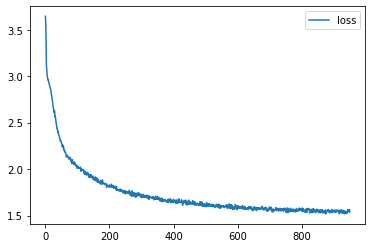

In [8]:
# train RNN model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
rnn_model = VanillaRNN(len(tokens))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-2)
train_model(rnn_model, criterion, optimizer)

In [9]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=100, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    char_rnn.to(torch.device('cpu'))
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1, device='cpu')
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        x = F.one_hot(x_sequence[: , i], num_classes=len(idx_to_token)).float()
        out, hid_state = char_rnn(x, hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        x = F.one_hot(x_sequence[: , -1], num_classes=len(idx_to_token)).float()
        out, hid_state = char_rnn(x, hid_state)

        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [10]:
print(generate_sample(rnn_model, seed_phrase=' ', max_length=500, temperature=0.3))

 that hath thy store the dear,
  and the self all the world the summer the beauty store when thy place to receives of the stall thou art doth doth sweet the world a doth store the will the would the seem be gives the word.
    and shall of the self strence strence the self a seen stanted the stall the since i love the world a jackent in the seem be the seem be noth the dear,
  and what i not that i love the so thy love the set stril make the beauty self a death i see a fair straight the self a l


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [11]:
class VanillaLSTM(nn.Module):
    """simple LSTM cell"""
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # define lstm cell and output function
        self.lstm = nn.LSTMCell(self.vocab_size, self.hidden_size)
        self.to_output = nn.Linear(self.hidden_size, self.vocab_size)
    
    def forward(self, x, hidden):
        output, context = hidden
        output, context = self.lstm(x, (output, context))
        out = self.to_output(output)
            
        return out, (output, context)    
    
    def initial_state(self, batch_size, device):
        # initialize output and context of LSTM
        return (torch.zeros(batch_size, self.hidden_size).to(device), torch.zeros(batch_size, self.hidden_size).to(device))

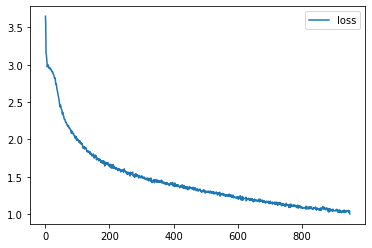

In [12]:
# train LSTM model

lstm_model = VanillaLSTM(vocab_size=len(tokens), hidden_size=128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
train_model(lstm_model, criterion, optimizer)

If we compare the loss of RNN model and LSTM model we can see that LSTM reached the lower loss of around 1.0, while RNN had loss of 1.5

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [13]:
# Text generation with different temperature values here

temp = [0.1, 0.2, 0.5, 1.0, 2.0]
for t in temp:
    print('------------------------------------------')
    print('------------------------------------------')
    print('------------------------------------------')
    print(f'Temperature: {t}')
    print(generate_sample(lstm_model, seed_phrase=' ', max_length=500, temperature=t))
    

------------------------------------------
------------------------------------------
------------------------------------------
Temperature: 0.1
 the state with the stays seen the world's sweet.

  cxxxvi

  what is the stard beauty seen deeds constance to shave,
  and some in the breath they see are bright
  which in the fairest a power,
  which in the world music part mother's part.
    the sad it thou art me a sav'd their dear sele,
  and therefore to my summer's dearest;
  and the still love with me not be the faires reason,
  for thou art thy sweet self dost heart grace,
  and this to the world music to stands to me so stain,
  and 
------------------------------------------
------------------------------------------
------------------------------------------
Temperature: 0.2
 the starn'd thee,
  and then that shows i have respect,
  but that which thou art long still face shall still,
  and thou this thy soul with thou art so sake
  as a mortal tomber's part, and dead the substa

Lower temperature values are producing more realistic outputs, while higher temperature outputs are chaotic.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [14]:
# Saving and loading code here
MODEL_FILE_PATH = 'lstm_model.pth'
with open(MODEL_FILE_PATH, 'wb') as model_file:
    torch.save(lstm_model.state_dict(), model_file)

In [15]:
loaded_lstm_model = VanillaLSTM(vocab_size=len(token_to_idx), hidden_size=128)
with open(MODEL_FILE_PATH, 'rb') as model_file:
    model_dict = torch.load(model_file)
    loaded_lstm_model.load_state_dict(model_dict)

In [16]:
print(generate_sample(loaded_lstm_model, seed_phrase=' ', max_length=500, temperature=0.3))

 the state with the sweet self dost.

  xxv

  or what is the dime to the partst to my show anort
  the leasuie, but the substance things to the self so,
  though my muse would live your sweet self dost heart
  to west, and think on the world music pea farthers,
  and duet in their praise to best compain.

  cxi

  love is muse, that this show the substant stark'd are ge.

  liii

  all thou art more lovely all men'd with looks,
  and proud of the substant thought thee,
  and beauty shall not ma


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)